In [26]:
%pylab inline

import matplotlib.pyplot as plt
import requests
import zipfile
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab


from functools import partial,reduce
from tqdm import tqdm, trange
tqdm = partial(tqdm, position=0, leave=True)
trange = partial(trange, position=0, leave=True)

import numpy as np


DEVICE = 'cuda:0'

Populating the interactive namespace from numpy and matplotlib


In [27]:
url = 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip'

r = requests.get(url)

ul = url.split('/')
name = ul[len(ul) - 1]

with open(name, 'wb') as file:
  file.write(r.content)

with zipfile.ZipFile(name, "r") as zip_ref:
  zip_ref.extractall("./")

!mv 'cornell movie-dialogs corpus' 'data'
!ls 'data'

 chameleons.pdf			 movie_lines.txt
'cornell movie-dialogs corpus'	 movie_titles_metadata.txt
 movie_characters_metadata.txt	 raw_script_urls.txt
 movie_conversations.txt	 README.txt


In [28]:
FIELD_SPLITTER = '+++$+++'

MAX_SAMPLES = 50000
MAX_LENGTH = 40

UNK_TOKEN = '<unk>'
PAD_TOKEN = '<PAD>'
BOS_TOKEN = '<BOS>'
EOS_TOKEN = '<EOS>'

UNK_TOKEN_IND = 0
PAD_TOKEN_IND = 1
BOS_TOKEN_IND = 2
EOS_TOKEN_IND = 3

BATCH = 128

In [29]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [30]:
text_transform = lambda x, voc, tokenizer: [voc['<BOS>']] + [voc[token] for token in tokenizer(x)] + [voc['<EOS>']]

In [31]:
# this is terrible as fuck because torchtext is terrible as fuck
def load_conversations(path_to_movie_lines, path_to_movie_conversations):
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.replace('\n', '').split(' +++$+++ ')
            id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.replace('\n', '').split(' +++$+++ ')
            conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
            for i in range(len(conversation) - 1):
                inputs.append(preprocess_sentence(id2line[conversation[i]]))
                outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
                if len(inputs) >= MAX_SAMPLES:
                    return inputs, outputs
    return inputs, outputs


In [32]:
def get_dataloader(path_to_movie_lines,
                   path_to_movie_conversations):
    questions, answers = load_conversations(path_to_movie_lines, path_to_movie_conversations)

    tokenizer = get_tokenizer('basic_english')

    counter = Counter()
    for sent in questions + answers:
        counter.update(tokenizer(sent))

    voc = vocab(counter)
    voc.insert_token(token=UNK_TOKEN, index=UNK_TOKEN_IND)
    voc.set_default_index(index=UNK_TOKEN_IND)
    voc.insert_token(token=PAD_TOKEN, index=PAD_TOKEN_IND)
    voc.insert_token(token=BOS_TOKEN, index=BOS_TOKEN_IND)
    voc.insert_token(token=EOS_TOKEN, index=EOS_TOKEN_IND)

    q_tokenized = [text_transform(t, voc, tokenizer) for t in questions]
    a_tokenized = [text_transform(t, voc, tokenizer) for t in answers]

    import tensorflow as tf # todo
    q_padded = tf.keras.preprocessing.sequence.pad_sequences(
        q_tokenized, maxlen=MAX_LENGTH, padding='post', value=1.0)

    a_padded = tf.keras.preprocessing.sequence.pad_sequences(
        a_tokenized, maxlen=MAX_LENGTH, padding='post', value=1.0)

    print("Vocab len", len(voc))

    dataloader = DataLoader(
        list(
            zip(
                  q_padded.astype(np.float32),
                  a_padded.astype(np.float32),
                )
            ),
            batch_size=BATCH,
            shuffle=False,
    )

    print(voc)
    torch.save(voc, 'vocab')

    return dataloader, text_transform, voc


In [33]:
lines_path = 'data/movie_lines.txt'
conversations_path = 'data/movie_conversations.txt'    

dataloader, text_transform, voc = get_dataloader(lines_path,
                                                 conversations_path)

Vocab len 23068
Vocab()


In [34]:
test_sample = None

for i,x in enumerate(dataloader):
  if i > 1: break
  print(x[0].shape)
  test_sample = x[0]

torch.Size([128, 40])
torch.Size([128, 40])


In [35]:
# https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.oreilly.com%2Flibrary%2Fview%2Fneural-networks-and%2F9781492037354%2Fassets%2Fmlst_1413.png&f=1&nofb=1
class myLSTM(nn.Module):
  def __init__(self, isize, osize):
    super(myLSTM, self).__init__()

    self.isize = isize
    self.osize = osize

    # sizes are questionable
    self.f = nn.Linear(isize, osize)
    self.g = nn.Linear(isize, osize)
    self.i = nn.Linear(isize, osize)
    self.o = nn.Linear(isize, osize)

    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forget_gate(self, h, x, c):
    fho = self.f(h)
    fxo = self.f(x)

    fo = fho + fxo
    fos = self.sigmoid(fo)
    out = torch.mul(c, fos)

    return out

  def input_gate(self, h, x):
    gho = self.g(h)
    gxo = self.g(x)
    go = gho + gxo
    gto = self.tanh(go)

    iho = self.i(h)
    ixo = self.i(x)
    io = iho + ixo
    ito = self.sigmoid(io)

    out = torch.mul(gto, ito)

    return out

  def output_gate(self, h, x, cn):
    oho = self.o(h)
    oxo = self.o(x)
    oo = oho + oxo

    out = torch.mul(oo, cn)

    return out

  def forward(self, x, h0=None, c0=None):
    if not h0:
      h0 = torch.zeros(x.shape[0], self.isize)
    if not c0:
      c0 = torch.zeros(x.shape[0], self.osize)

    fg_out = self.forget_gate(h0, x, c0)
    ig_out = self.input_gate(h0, x)

    c_new = fg_out + ig_out

    cnt = self.tanh(c_new) 

    h_new = self.output_gate(h0, x, c_new)

    out = h_new

    # is this for real how it's done?
    return out, (h_new[len(h_new) - 1].reshape(1, self.osize),
                 c_new[len(h_new) - 1].reshape(1, self.osize))


In [36]:
my_lstm = myLSTM(40, 80)

for p in my_lstm.parameters():
  print(p.shape)

print('\n')

out, (h, c) = my_lstm(test_sample)

print(out.shape)
print('\n----------------')
print(h.shape)
print('\n----------------')
print(c.shape)

torch.Size([80, 40])
torch.Size([80])
torch.Size([80, 40])
torch.Size([80])
torch.Size([80, 40])
torch.Size([80])
torch.Size([80, 40])
torch.Size([80])


torch.Size([128, 80])

----------------
torch.Size([1, 80])

----------------
torch.Size([1, 80])


In [37]:
print(test_sample.shape)
print(test_sample.dtype)

torch.Size([128, 40])
torch.float32


In [38]:
t_lstm = nn.LSTM(40, 80, batch_first=True)

for p in t_lstm.parameters():
  print(p.shape)

print('\n')

res, (h_s, c_s) = t_lstm(test_sample)

print(res.shape)
print('\n---------')
print(h_s.shape)
print('\n---------')
print(c_s.shape)
print('\n---------')

torch.Size([320, 40])
torch.Size([320, 80])
torch.Size([320])
torch.Size([320])


torch.Size([128, 80])

---------
torch.Size([1, 80])

---------
torch.Size([1, 80])

---------


In [39]:
class Encoder(nn.Module):
  def __init__(self):
      super(Encoder, self).__init__()
      self.lstm = nn.LSTM(40, 80, batch_first=True)

  def forward(self, x):
    x, (h, c) = self.lstm(x)
    return x, (h, c)

In [40]:
class Decoder(nn.Module):
  def __init__(self):
      super(Decoder, self).__init__()
      self.lstm = nn.LSTM(80, 80, batch_first=True)
      self.lin = nn.Linear(80, 40)

  def forward(self, x):
    e_o, (h, c) = x
    o, _ = self.lstm(e_o, (h, c))
    o = self.lin(o)
    return x

In [57]:
encoder = Encoder().to(DEVICE)
decoder = Decoder().to(DEVICE)

e_optim = optim.Adam(params=encoder.parameters(), lr=0.001)
d_optim = optim.Adam(params=decoder.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss().to(DEVICE)

EPOCHS = 4

losses = []

In [58]:
for epoch in trange(EPOCHS):
  for i, data in tqdm(enumerate(dataloader)):
    i_seq = data[0].to(DEVICE)

    e_out = encoder(i_seq)
    d_out, _ = decoder(e_out)

    loss = loss_fn(e_out[0], d_out)

    e_optim.zero_grad()
    d_optim.zero_grad()

    loss.backward()

    losses.append(loss.item())

    e_optim.step()
    d_optim.step()

391it [00:02, 174.12it/s]
391it [00:02, 177.88it/s]
391it [00:02, 177.87it/s]
391it [00:02, 179.40it/s]
100%|██████████| 4/4 [00:08<00:00,  2.21s/it]


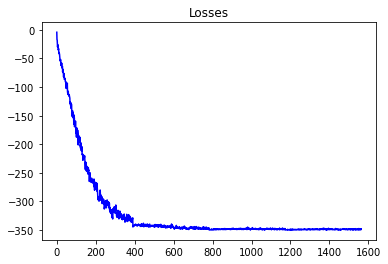

In [59]:
plt.plot(range(len(losses)), losses, 'b', label='Loss')
plt.title('Losses')
plt.show()

In [63]:
query = 'test'

q_tr = text_transform(query, voc, get_tokenizer('basic_english'))
import tensorflow as tf
q_p = tf.keras.preprocessing.sequence.pad_sequences(
    [q_tr],
    maxlen=MAX_LENGTH,
    padding='post',
    value=1.0
)
q_t = torch.Tensor(q_p).int().to(DEVICE)


enc, _ = encoder(q_t)
dec = decoder(enc)

int_infer = dec.int()

tokens = [t.item() for t in int_infer[0]]
words = voc.get_itos()
result = ' '.join(list(filter(lambda w: '<' not in w and '>' not in w, [words[t] for t in tokens])))
print(result)



RuntimeError: ignored

In [46]:
!tail -n 10 data/movie_conversations.txt 

u9027 +++$+++ u9029 +++$+++ m616 +++$+++ ['L666460', 'L666461']
u9027 +++$+++ u9029 +++$+++ m616 +++$+++ ['L666485', 'L666486']
u9027 +++$+++ u9029 +++$+++ m616 +++$+++ ['L666546', 'L666547']
u9028 +++$+++ u9033 +++$+++ m616 +++$+++ ['L666497', 'L666498', 'L666499', 'L666500', 'L666501', 'L666502']
u9028 +++$+++ u9031 +++$+++ m616 +++$+++ ['L666262', 'L666263', 'L666264']
u9028 +++$+++ u9031 +++$+++ m616 +++$+++ ['L666324', 'L666325', 'L666326', 'L666327']
u9028 +++$+++ u9031 +++$+++ m616 +++$+++ ['L666575', 'L666576']
u9030 +++$+++ u9034 +++$+++ m616 +++$+++ ['L666256', 'L666257']
u9030 +++$+++ u9034 +++$+++ m616 +++$+++ ['L666369', 'L666370', 'L666371', 'L666372']
u9030 +++$+++ u9034 +++$+++ m616 +++$+++ ['L666520', 'L666521', 'L666522']


In [47]:
!ls data

 chameleons.pdf			 movie_lines.txt
'cornell movie-dialogs corpus'	 movie_titles_metadata.txt
 movie_characters_metadata.txt	 raw_script_urls.txt
 movie_conversations.txt	 README.txt


In [48]:
!cat data/README.txt

Cornell Movie-Dialogs Corpus

Distributed together with:

"Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs"
Cristian Danescu-Niculescu-Mizil and Lillian Lee
Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics, ACL 2011.

(this paper is included in this zip file)

NOTE: If you have results to report on these corpora, please send email to cristian@cs.cornell.edu or llee@cs.cornell.edu so we can add you to our list of people using this data.  Thanks!


Contents of this README:

	A) Brief description
	B) Files description
	C) Details on the collection procedure
	D) Contact


A) Brief description:

This corpus contains a metadata-rich collection of fictional conversations extracted from raw movie scripts:

- 220,579 conversational exchanges between 10,292 pairs of movie characters
- involves 9,035 characters from 617 movies
- in total 304,713 utterances
- movie metadata included:
	- genres
	- relea

In [49]:
# # trash




# def preprocess(x):
#   x_no_new = x.replace('\n', '')
#   text = x_no_new.split(FIELD_SPLITTER).pop()
#   embedding = g_vectors.get_vecs_by_tokens(tokenizer(text), lower_case_backup=True)
#   return embedding

# tokenizer = get_tokenizer('basic_english')
# g_vectors = GloVe(name='840B')
# g_vocab = vocab(g_vectors.stoi)


# train_iter = tt.data.BucketIterator(
#   dataset=train_obj,
#   batch_size = 2,
#   sort_key=lambda x: len(x.review),
#   shuffle=True,
#   device=DEVICE
# )

# trainloader = torch.utils.data.DataLoader(
# 	,
# 	batch_size=BATCH,
# 	num_workers=12,
# 	shuffle=True
# )

In [50]:

# embeddings = global_vectors.get_vecs_by_tokens(tokenizer("Hello, How are you?"),
#                                                lower_case_backup=True)
# embeddings
# 
# 
# 
# def batch(iterable, size):
#     from itertools import chain, islice
#     iterator = iter(iterable)
#     for first in iterator:
#         yield list(chain([first], islice(iterator, size - 1)))